### 28.04.25, © Dmytro Sokhin KI-21-1, 2025

Source: https://github.com/https-deeplearning-ai/tensorflow-1-public

# Workshop 3 Assignment 1: Using CNN's with the Cats vs Dogs Dataset

You will be using the famous `Cats vs Dogs` dataset to train a model that can classify images of dogs from images of cats. For this, you will create your own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities.

You will also create some helper functions to move the images around the filesystem so if you are not familiar with the `os` module be sure to take a look a the [docs](https://docs.python.org/3/library/os.html).

Let's get started!

_**NOTE:** To prevent errors from the autograder, please avoid editing or deleting non-graded cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and refrain from adding any new cells._

In [38]:
# grader-required-cell

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras import layers, models 
from shutil import copyfile
import matplotlib.pyplot as plt
import requests
from tqdm.notebook import tqdm 
import urllib3
import glob

Download the dataset from its original source by running the cell below. 

Note that the `zip` file that contains the images is unzipped under the `/data` directory.

In [3]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"


base_dir = './data/'
zip_save_path = os.path.join(base_dir, 'cats-and-dogs.zip')
extract_path = base_dir 

os.makedirs(base_dir, exist_ok=True)
print(f"Will save zip to: {os.path.abspath(zip_save_path)}")
print(f"Will extract to: {os.path.abspath(extract_path)}")

try:
    print("Starting download...")
    response = requests.get(url, stream=True) 
    response.raise_for_status() 
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024 

    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
    with open(zip_save_path, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()

    if total_size != 0 and progress_bar.n != total_size:
        print("ERROR, download size mismatch")
    else:
        print(f"Download completed successfully: {zip_save_path}")

        print(f"Extracting zip file...")
        try:
            with zipfile.ZipFile(zip_save_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"Successfully extracted to {extract_path}")

        except zipfile.BadZipFile:
            print(f"ERROR: Failed to unzip file. It might be corrupted.")
        except Exception as e:
            print(f"An error occurred during extraction: {e}")


except requests.exceptions.RequestException as e:
    print(f"Error during download: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Will save zip to: c:\Users\user\Downloads\Workshop\data\cats-and-dogs.zip
Will extract to: c:\Users\user\Downloads\Workshop\data
Starting download...


  0%|          | 0.00/825M [00:00<?, ?iB/s]

Download completed successfully: ./data/cats-and-dogs.zip
Extracting zip file...
Successfully extracted to ./data/


Now the images are stored within the `/data/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [6]:
base_extracted_path = './data/' 
source_path = os.path.join(base_extracted_path, 'PetImages') 

if not os.path.isdir(source_path):
    print(f"ERROR: Directory '{source_path}' does not exist!")
    print("Please ensure the dataset was extracted correctly and the path is right.")
else:
    print(f"Using source path: {os.path.abspath(source_path)}")

    source_path_dogs = os.path.join(source_path, 'Dog')
    source_path_cats = os.path.join(source_path, 'Cat')

    print("Deleting non-JPG files...")
    files_deleted_count = 0
    all_files = glob.glob(os.path.join(source_path, '**', '*'), recursive=True)

    for file_path in all_files:
        if os.path.isfile(file_path) and not file_path.lower().endswith(".jpg"):
            print(f"Deleting: {file_path}")
            try:
                os.remove(file_path)
                files_deleted_count += 1
            except OSError as e:
                print(f"Error deleting file {file_path}: {e}")

    print(f"Deleted {files_deleted_count} non-JPG files.")

    try:
        num_dog_images = len([f for f in os.listdir(source_path_dogs) if os.path.isfile(os.path.join(source_path_dogs, f))])
        print(f"There are {num_dog_images} images of dogs.")
    except FileNotFoundError:
        print(f"ERROR: Dog directory not found at '{source_path_dogs}'")
    except Exception as e:
        print(f"An error occurred counting dog images: {e}")

    try:
        num_cat_images = len([f for f in os.listdir(source_path_cats) if os.path.isfile(os.path.join(source_path_cats, f))])
        print(f"There are {num_cat_images} images of cats.")
    except FileNotFoundError:
        print(f"ERROR: Cat directory not found at '{source_path_cats}'")
    except Exception as e:
        print(f"An error occurred counting cat images: {e}")

Using source path: c:\Users\user\Downloads\Workshop\data\PetImages
Deleting non-JPG files...
Deleting: ./data/PetImages\Cat\Thumbs.db
Deleting: ./data/PetImages\Dog\Thumbs.db
Deleted 2 non-JPG files.
There are 12500 images of dogs.
There are 12500 images of cats.


**Expected Output:**

```
There are 12500 images of dogs.
There are 12500 images of cats.
```

You will need a directory for cats-v-dogs, and subdirectories for training
and validation. These in turn will need subdirectories for 'cats' and 'dogs'. To accomplish this, complete the `create_train_val_dirs` below:

In [30]:
# grader-required-cell

base_data_dir = './data/'
root_dir = os.path.join(base_data_dir, 'cats-v-dogs')

print(f"Attempting to create structure in: {os.path.abspath(root_dir)}") 

# GRADED FUNCTION: create_train_val_dirs 
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and validation sets
  
  Args:
    root_path (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """
  ### START CODE HERE
  training_dir_name = "training"
  validation_dir_name = "validation"
  cats_dir_name = "cats"
  dogs_dir_name = "dogs"

  training_dir_path = os.path.join(root_path, training_dir_name)
  train_cats_dir_path = os.path.join(training_dir_path, cats_dir_name)
  train_dogs_dir_path = os.path.join(training_dir_path, dogs_dir_name)

  validation_dir_path = os.path.join(root_path, validation_dir_name)
  validation_cats_dir_path = os.path.join(validation_dir_path, cats_dir_name)
  validation_dogs_dir_path = os.path.join(validation_dir_path, dogs_dir_name)

  os.makedirs(train_cats_dir_path)
  os.makedirs(train_dogs_dir_path)
  os.makedirs(validation_cats_dir_path)
  os.makedirs(validation_dogs_dir_path)

  print(f"Directory structure created under {os.path.abspath(root_path)}")
  print(f"- {os.path.abspath(training_dir_path)}")
  print(f"  - {os.path.abspath(train_cats_dir_path)}")
  print(f"  - {os.path.abspath(train_dogs_dir_path)}")
  print(f"- {os.path.abspath(validation_dir_path)}")
  print(f"  - {os.path.abspath(validation_cats_dir_path)}")
  print(f"  - {os.path.abspath(validation_dogs_dir_path)}")
  ### END CODE HERE

Attempting to create structure in: c:\Users\user\Downloads\Workshop\data\cats-v-dogs


In [32]:
# grader-required-cell

# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

./data/cats-v-dogs\cats
./data/cats-v-dogs\dogs
./data/cats-v-dogs\training
./data/cats-v-dogs\validation


**Expected Output (directory order might vary):**

``` txt
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs

```

Code the `split_data` function which takes in the following arguments:
- SOURCE_DIR: directory containing the files

- TRAINING_DIR: directory that a portion of the files will be copied to (will be used for training)
- VALIDATION_DIR: directory that a portion of the files will be copied to (will be used for validation)
- SPLIT_SIZE: determines the portion of images used for training.

The files should be randomized, so that the training set is a random sample of the files, and the validation set is made up of the remaining files.

For example, if `SOURCE_DIR` is `PetImages/Cat`, and `SPLIT_SIZE` is .9 then 90% of the images in `PetImages/Cat` will be copied to the `TRAINING_DIR` directory
and 10% of the images will be copied to the `VALIDATION_DIR` directory.

All images should be checked before the copy, so if they have a zero file length, they will be omitted from the copying process. If this is the case then your function should print out a message such as `"filename is zero length, so ignoring."`. **You should perform this check before the split so that only non-zero images are considered when doing the actual split.**


Hints:

- `os.listdir(DIRECTORY)` returns a list with the contents of that directory.

- `os.path.getsize(PATH)` returns the size of the file

- `copyfile(source, destination)` copies a file from source to destination

- `random.sample(list, len(list))` shuffles a list

In [33]:
# grader-required-cell

# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """

  ### START CODE HERE
  
  # Check if SOURCE_DIR exists
  if not os.path.exists(SOURCE_DIR):
      print(f"ERROR: Source directory {SOURCE_DIR} does not exist.")
      return

  # Get the list of all files in the source directory
  all_files = os.listdir(SOURCE_DIR)
  
  # Filter out zero-length files and create a list of valid files (filenames only)
  valid_files = []
  ignored_count = 0
  for filename in all_files:
      filepath = os.path.join(SOURCE_DIR, filename)
      # Ensure it's actually a file before checking size
      if os.path.isfile(filepath):
          if os.path.getsize(filepath) > 0:
              valid_files.append(filename)
          else:
              print(f"{filename} is zero length, so ignoring.")
              ignored_count += 1
      # else: # Optional: Handle if there are subdirectories in SOURCE_DIR
      #     print(f"Ignoring non-file item: {filename}")

  num_total_valid_files = len(valid_files)
  print(f"Found {num_total_valid_files} valid files (ignored {ignored_count} zero-length files).")

  # Check if there are any valid files to split
  if num_total_valid_files == 0:
      print("No valid files to split.")
      return
      
  # Shuffle the list of valid files randomly
  random.shuffle(valid_files) # Shuffles the list in place
  
  # Calculate the split index
  split_index = int(num_total_valid_files * SPLIT_SIZE)
  
  # Slice the list to get training and validation sets
  training_set = valid_files[:split_index]
  validation_set = valid_files[split_index:]
  
  print(f"Splitting into {len(training_set)} training files and {len(validation_set)} validation files.")

  # Ensure the destination directories exist (create them if needed)
  os.makedirs(TRAINING_DIR, exist_ok=True)
  os.makedirs(VALIDATION_DIR, exist_ok=True)

  # Copy files to the TRAINING directory
  copied_train = 0
  for filename in training_set:
      source_path = os.path.join(SOURCE_DIR, filename)
      destination_path = os.path.join(TRAINING_DIR, filename)
      try:
          shutil.copyfile(source_path, destination_path)
          copied_train += 1
      except Exception as e:
           print(f"Error copying {filename} to training dir: {e}")

  # Copy files to the VALIDATION directory
  copied_val = 0
  for filename in validation_set:
      source_path = os.path.join(SOURCE_DIR, filename)
      destination_path = os.path.join(VALIDATION_DIR, filename)
      try:
        shutil.copyfile(source_path, destination_path)
        copied_val += 1
      except Exception as e:
           print(f"Error copying {filename} to validation dir: {e}")

  print(f"Finished copying. {copied_train} files to training, {copied_val} files to validation.")

  ### END CODE HERE

In [35]:
# grader-required-cell

print("--- Starting Test Block for split_data (Using /data/ paths) ---")


SOURCE_DIR_BASE = os.path.join('data', 'PetImages') # Відносний шлях до PetImages
TARGET_DIR_BASE = os.path.join('data', 'cats-v-dogs') # Відносний шлях до структурованої папки

if not os.path.exists(SOURCE_DIR_BASE):
    print(f"ERROR: Base source directory '{SOURCE_DIR_BASE}' not found.")
    print("Please ensure the dataset was extracted correctly into '/data/PetImages/'.")
    CAT_SOURCE_DIR = None
    DOG_SOURCE_DIR = None
else:
    CAT_SOURCE_DIR = os.path.join(SOURCE_DIR_BASE, "Cat/")
    DOG_SOURCE_DIR = os.path.join(SOURCE_DIR_BASE, "Dog/")

if not os.path.exists(TARGET_DIR_BASE):
    print(f"ERROR: Base target directory '{TARGET_DIR_BASE}' not found.")
    print("Please ensure the directory structure was created in '/data/cats-v-dogs/' using 'create_train_val_dirs'.")
    TRAINING_DIR = None
    VALIDATION_DIR = None
else:
    TRAINING_DIR = os.path.join(TARGET_DIR_BASE, "training/")
    VALIDATION_DIR = os.path.join(TARGET_DIR_BASE, "validation/")

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/") if TRAINING_DIR else None
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/") if VALIDATION_DIR else None
TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/") if TRAINING_DIR else None
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/") if VALIDATION_DIR else None

dirs_to_clean = [TRAINING_CATS_DIR, TRAINING_DOGS_DIR, VALIDATION_CATS_DIR, VALIDATION_DOGS_DIR]
print("\nCleaning target directories (if they exist)...")
for dir_path in dirs_to_clean:
    if dir_path and os.path.exists(dir_path):
        try:
            file_count = 0
            with os.scandir(dir_path) as entries:
                for entry in entries:
                    if entry.is_file():
                        os.remove(entry.path)
                        file_count += 1
        except OSError as e:
            print(f"Error cleaning directory {dir_path}: {e}")

split_size = .9

print("\n--- Splitting Cat Data ---")
if CAT_SOURCE_DIR and TRAINING_CATS_DIR and VALIDATION_CATS_DIR:
    if os.path.exists(CAT_SOURCE_DIR):
        split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
    else:
        print(f"Skipping cat split: Source directory '{CAT_SOURCE_DIR}' not found.")
else:
    print("Skipping cat split due to missing paths.")

print("\n--- Splitting Dog Data ---")
if DOG_SOURCE_DIR and TRAINING_DOGS_DIR and VALIDATION_DOGS_DIR:
    if os.path.exists(DOG_SOURCE_DIR):
        split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)
    else:
        print(f"Skipping dog split: Source directory '{DOG_SOURCE_DIR}' not found.")
else:
     print("Skipping dog split due to missing paths.")

print("\n--- Verification ---")
def count_files(directory):
    if directory and os.path.exists(directory):
        try:
            return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])
        except Exception as e:
            print(f"Error counting files in {directory}: {e}")
            return "Error"
    return "N/A (dir not found or path undefined)"

if CAT_SOURCE_DIR and os.path.exists(CAT_SOURCE_DIR):
    print(f"Original cat's directory has {count_files(CAT_SOURCE_DIR)} images")
else:
    print(f"Original cat's directory ({CAT_SOURCE_DIR}) not found for verification.")

if DOG_SOURCE_DIR and os.path.exists(DOG_SOURCE_DIR):
     print(f"Original dog's directory has {count_files(DOG_SOURCE_DIR)} images\n")
else:
    print(f"Original dog's directory ({DOG_SOURCE_DIR}) not found for verification.\n")


print(f"There are {count_files(TRAINING_CATS_DIR)} images of cats for training")
print(f"There are {count_files(TRAINING_DOGS_DIR)} images of dogs for training")
print(f"There are {count_files(VALIDATION_CATS_DIR)} images of cats for validation")
print(f"There are {count_files(VALIDATION_DOGS_DIR)} images of dogs for validation")

print("\n--- Test Block Finished ---")

--- Starting Test Block for split_data (Using /data/ paths) ---

Cleaning target directories (if they exist)...

--- Splitting Cat Data ---
666.jpg is zero length, so ignoring.
Found 12499 valid files (ignored 1 zero-length files).
Splitting into 11249 training files and 1250 validation files.
Finished copying. 11249 files to training, 1250 files to validation.

--- Splitting Dog Data ---
11702.jpg is zero length, so ignoring.
Found 12499 valid files (ignored 1 zero-length files).
Splitting into 11249 training files and 1250 validation files.
Finished copying. 11249 files to training, 1250 files to validation.

--- Verification ---
Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation

--- Test Block Finished ---


**Expected Output:**

```
666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation
```

Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this, complete the `train_val_generators` function below.

Something important to note is that the images in this dataset come in a variety of resolutions. Luckily, the `flow_from_directory` method allows you to standarize this by defining a tuple called `target_size` that will be used to convert each image to this target resolution. **For this exercise, use a `target_size` of (150, 150)**.

**Hint:** 

Don't use data augmentation by setting extra parameters when you instantiate the `ImageDataGenerator` class. This will make the training of your model to take longer to reach the necessary accuracy threshold to pass this assignment and this topic will be covered in the next week.

In [36]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images 
                           (should contain subdirectories for 'cats' and 'dogs')
    VALIDATION_DIR (string): directory path containing the validation images
                             (should contain subdirectories for 'cats' and 'dogs')
    
  Returns:
    tuple containing the training and validation generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class for training data
  # Rescale pixel values from [0, 255] to [0, 1]
  train_datagen = ImageDataGenerator(rescale=1.0/255.0)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,       # Target directory for training images
      batch_size=20,                # Size of batches to generate (a common choice)
      class_mode='binary',          # For 2 classes (cats/dogs), returns 1D binary labels (0 or 1)
      target_size=(150, 150)        # Resize all images to 150x150
  )

  # Instantiate the ImageDataGenerator class for validation data
  # IMPORTANT: Only rescale validation data, do not apply augmentation
  validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,     # Target directory for validation images
      batch_size=20,                # Size of batches (usually same as training)
      class_mode='binary',          # For 2 classes
      target_size=(150, 150)        # Resize all images to 150x150 (must match training)
  )
  ### END CODE HERE
  return train_generator, validation_generator

In [37]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


**Expected Output:**

```
Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
```


One last step before training is to define the architecture of the model that will be trained.

Complete the `create_model` function below which should return a Keras' `Sequential` model.

Aside from defining the architecture of the model, you should also compile it so make sure to use a `loss` function that is compatible with the `class_mode` you defined in the previous exercise, which should also be compatible with the output of your network. You can tell if they aren't compatible if you get an error during training.

**Note that you should use at least 3 convolution layers to achieve the desired performance.**

In [39]:
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  ### START CODE HERE

  model = tf.keras.models.Sequential([
      # Note the input shape is the desired size of the image 150x150 with 3 bytes color
      # 1st convolution
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      # 2nd convolution
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # 3rd convolution
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
      # Sigmoid activation is used for binary classification
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile the model
  model.compile(optimizer=RMSprop(learning_rate=0.001), 
                loss='binary_crossentropy', 
                metrics=['accuracy']) 

  ### END CODE HERE

  return model

Now it is time to train your model!

**Note:** You can ignore the `UserWarning: Possibly corrupt EXIF data.` warnings.

In [40]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
  74/1125 ━━━━━━━━━━━━━━━━━━━━ 11:01 629ms/step - accuracy: 0.5150 - loss: 1.1011

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 766s 678ms/step - accuracy: 0.6173 - loss: 0.6780 - val_accuracy: 0.7676 - val_loss: 0.4821
Epoch 2/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 627s 558ms/step - accuracy: 0.7701 - loss: 0.4811 - val_accuracy: 0.8040 - val_loss: 0.4387
Epoch 3/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 657s 584ms/step - accuracy: 0.8275 - loss: 0.3906 - val_accuracy: 0.8196 - val_loss: 0.4078
Epoch 4/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 657s 584ms/step - accuracy: 0.8655 - loss: 0.3157 - val_accuracy: 0.8236 - val_loss: 0.3912
Epoch 5/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 650s 577ms/step - accuracy: 0.9040 - loss: 0.2372 - val_accuracy: 0.8212 - val_loss: 0.4092
Epoch 6/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 661s 558ms/step - accuracy: 0.9454 - loss: 0.1418 - val_accuracy: 0.8028 - val_loss: 0.6252
Epoch 7/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 664s 590ms/step - accuracy: 0.9718 - loss: 0.0783 - val_accuracy: 0.8292 - val_loss: 0.7038
Epoch 8/15
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 650s 577ms/step - accuracy: 0.9

Once training has finished, you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

**To pass this assignment, your model should achieve a training accuracy of at least 95% and a validation accuracy of at least 80%**. If your model didn't achieve these thresholds, try training again with a different model architecture and remember to use at least 3 convolutional layers.

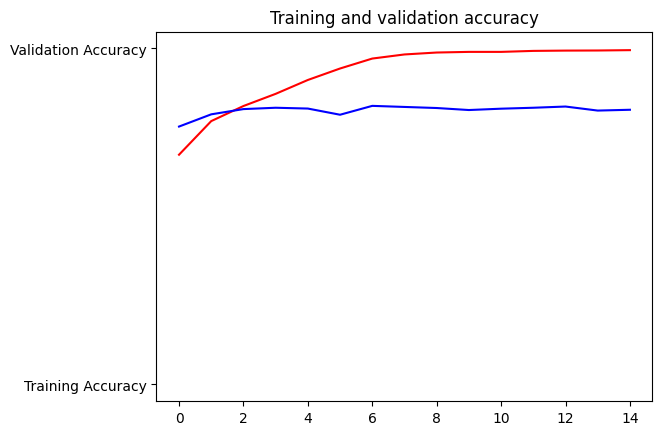

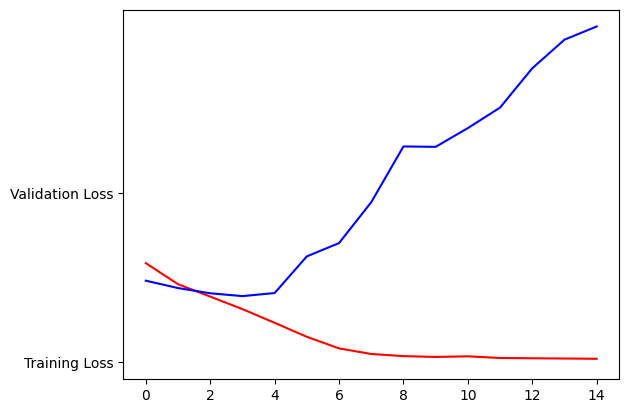

In [41]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

You will probably encounter that the model is overfitting, which means that it is doing a great job at classifying the images in the training set but struggles with new data. This is perfectly fine and you will learn how to mitigate this issue in the upcoming week.

Before downloading this notebook and closing the assignment, be sure to also download the `history.pkl` file which contains the information of the training history of your model. You can download this file by running the cell below:

In [43]:
import pickle
import os 

def save_history_local(history_obj, filename='history.pkl'):
  """Saves the training history locally using pickle."""
  try:
      if hasattr(history_obj, 'history') and isinstance(history_obj.history, dict):
          with open(filename, 'wb') as f:
              pickle.dump(history_obj.history, f)
          print(f"History successfully saved to: {os.path.abspath(filename)}")
      else:
          print("Error: Input object does not have a valid 'history' attribute (dictionary).")
  except Exception as e:
      print(f"An error occurred while saving the history: {e}")

if 'history' in locals() and history is not None:
  save_history_local(history)
else:
  print("Variable 'history' not found or is None. Cannot save history.")

History successfully saved to: c:\Users\user\Downloads\Workshop\history.pkl


## Download your notebook for grading

Along with the `history.pkl` file, you will also need to submit your solution notebook for grading. 